In [39]:
import os
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torchvision import datasets, transforms, models
from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np
import cv2
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive

In [2]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


Define Directories

In [3]:
train_folder = "/kaggle/input/fake-or-real-dataset/train/"
val_folder = "/kaggle/input/fake-or-real-dataset/test/"
epochs = 100
lr = 0.003

Prepare Datasets

In [4]:
# Define transforms
transform_enb3 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
full_data = datasets.ImageFolder(root=train_folder, transform=transform_enb3)
full_data.classes[0] = 1 # set fake as 1
full_data.classes[1] = 0 # set real as 0

val_data = datasets.ImageFolder(root=val_folder, transform=transform_enb3)
val_data.classes[0] = 1 # set fake as 1

# Define train-test split ratio
train_size = int(0.8 * len(full_data))
test_size = len(full_data) - train_size

# Split the dataset
train_data, test_data = torch.utils.data.random_split(full_data, [train_size, test_size])

# Create DataLoader for each dataset
batch_size = 256
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size, shuffle=False)

# Print number of samples in each split
print(f'Training samples: {len(train_data)}')
print(f'Testing samples: {len(test_data)}')

Training samples: 16000
Testing samples: 4000


testing dataloaders with 5 random photos

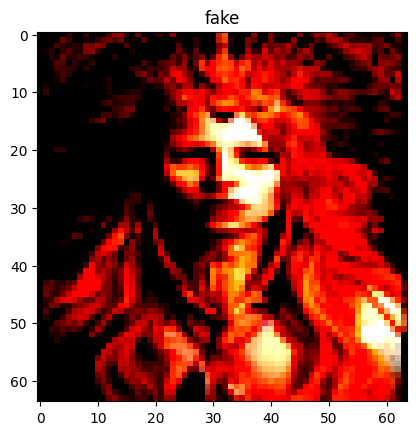

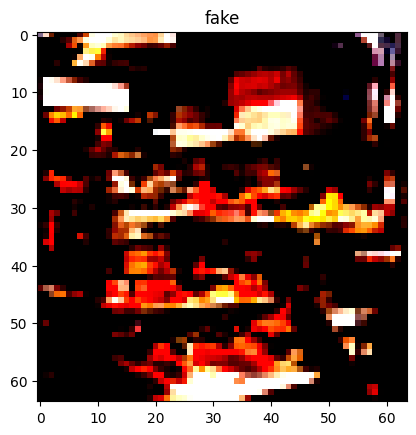

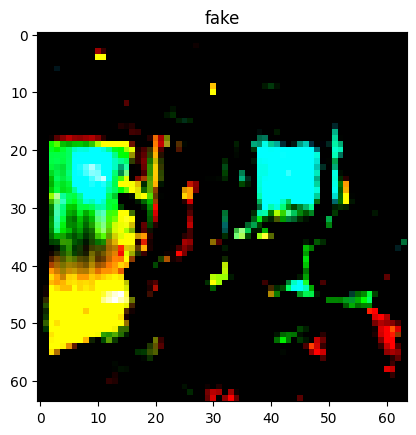

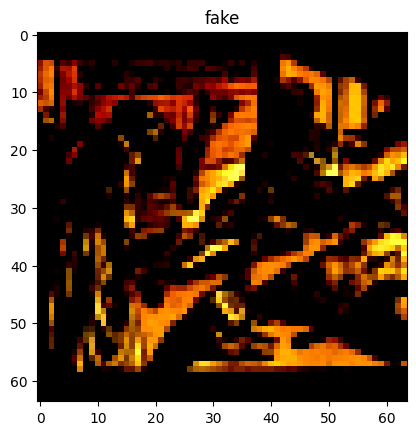

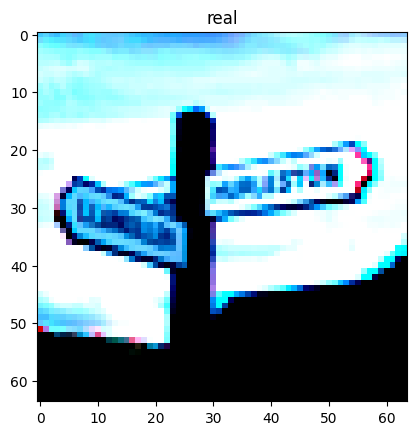

In [5]:
i = 0
for images, labels in train_loader:  # Assuming train_loader gives a batch of images and labels
    if i >= 5:
        break
    
    # Access the first image in the batch and permute dimensions
    image = images[0].permute(1, 2, 0)
    
    # Display the image
    plt.imshow(image)
    plt.title("real" if labels[0].item() == 1 else "fake")
    plt.show()
    
    i += 1

In [7]:
from tqdm import tqdm
# Training loop
def train_model(model, criterion, optimizer, dataloaders, classification_layer,finetuning_lr,num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Use tqdm to wrap the dataloader
            phase_dataloader = tqdm(dataloaders[phase], desc=phase)
            for inputs, labels in phase_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                if phase == "train":
                    if epoch >= 0.8 * num_epochs:
                        # Unfreeze all layers for fine-tuning
                        for param in model.parameters():
                            param.requires_grad = True
                        optimizer.param_groups[0]['lr'] = finetuning_lr
                    else:
                        # Freeze the CNN part
                        for param in model.parameters():
                            param.requires_grad = False
                        # Unfreeze the classification layer
                        for param in classification_layer.parameters():
                            param.requires_grad = True
                elif phase == "val":
                    for param in model.parameters():
                            param.requires_grad = False

                        
                outputs = model(inputs)
                preds = torch.sigmoid(outputs)
                preds = (preds > 0.5).float()
#                 print(preds)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        print()

    return model

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        val_dataloader = tqdm(dataloader, desc="validation")
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            labels = torch.ones(outputs.size()).to(device)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            preds = (torch.sigmoid(outputs) > 0.5) * 1
#             print(preds)
            all_labels.append(labels)
            all_preds.append(preds)

    # Move all predictions and labels to CPU once
    all_labels = torch.cat(all_labels).cpu().numpy()
    all_preds = torch.cat(all_preds).cpu().numpy()

    epoch_loss = running_loss / len(dataloader.dataset)
#     print(all_labels)
#     print(all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f'Test Loss: {epoch_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    return epoch_loss, accuracy, precision, recall, f1

In [56]:
import datetime as dt
def save_model(model, model_name,model_evaluation_history):
    model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
    # Define the string date format.
    # Get the current Date and Time in a DateTime Object.
    # Convert the DateTime object to string according to the style mentioned in date_time_format string.
    date_time_format = '%Y_%m_%d__%H_%M_%S'
    current_date_time_dt = dt.datetime.now()
    current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

    # Define a useful name for our model to make it easy for us while navigating through multiple saved models.
    model_file_name = f'{model_name}___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.pth'

    # Save your Model.
    torch.save(model.state_dict(), f'{model_file_name}_entire_dict')
    torch.save(model, f'{model_file_name}_entire')

def load_model(model_path):
    # Load the object from the file
    loaded_model = torch.load(model_path)
    loaded_model.eval()
    
    return loaded_model

## **EfficientNet Training**

In [ ]:

model = efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
dataloaders = {'train' : train_loader, 'val' : test_loader}
device = "cuda"
# Modify the classifier to fit the binary classification problem
num_features = model.classifier.fc.in_features
model.classifier.fc = nn.Linear(num_features, 1)  # Output layer for binary classification

# Move the model to the appropriate device
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss with logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = train_model(model, criterion, optimizer, dataloaders, model.classifier.fc ,10e-6)

epoch_loss, accuracy, precision, recall, f1 = test_model(model, val_loader, criterion, device)

save_model(model, "efficientnet-B0", (epoch_loss, accuracy))


## **ResNet Training**

In [10]:
model = models.resnet18(pretrained=True)
dataloaders = {'train' : train_loader, 'val' : test_loader}
device = "cuda"
# Modify the classifier to fit the binary classification problem
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Output layer for binary classification

# Move the model to the appropriate device
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss with logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = train_model(model, criterion, optimizer, dataloaders,model.fc ,10e-6, num_epochs=1)

# epoch_loss, accuracy, precision, recall, f1 = test_model(model, val_loader, criterion, device)

save_model(model, "ResNet-18", (0, 0))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 59.8MB/s]


Epoch 0/0
----------


train: 100%|██████████| 63/63 [06:01<00:00,  5.74s/it]


train Loss: 0.5550 Acc: 0.7159


val: 100%|██████████| 16/16 [01:31<00:00,  5.73s/it]

val Loss: 0.4726 Acc: 0.7742



## **ResNext**

In [ ]:
# Define the dataloaders
dataloaders = {'train': train_loader, 'val': test_loader}

# Set device to GPU if available
device = torch.device("cuda")

# Load the ResNeXt model with pretrained weights
model = models.resnext50_32x4d(pretrained=True)

# Modify the classifier to fit the binary classification problem
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Output layer for binary classification

# Move the model to the appropriate device
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss with logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = train_model(model, criterion, optimizer, dataloaders, model.fc, 10e-6, num_epochs=2)

epoch_loss, accuracy, precision, recall, f1 = test_model(model, val_loader, criterion, device)

save_model(model, "resnext50_32x4d", (epoch_loss, accuracy))

## **VGG**

In [ ]:
# Define the dataloaders
dataloaders = {'train': train_loader, 'val': test_loader}

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the VGG model with pretrained weights
model = models.vgg16(pretrained=True)

# Modify the classifier to fit the binary classification problem
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 1)  # Output layer for binary classification

# Move the model to the appropriate device
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss with logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = train_model(model, criterion, optimizer, dataloaders, model.classifier[6], 10e-6)

epoch_loss, accuracy, precision, recall, f1 = test_model(model, val_loader, criterion, device)

save_model(model, "vgg16", (epoch_loss, accuracy))

# **Grad-CAM**

In [29]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.features = None

        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.features = output
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def get_cam_weights(self):
        return torch.mean(self.gradients, dim=(2, 3), keepdim=True)

    def generate_heatmap(self, features):
        weights = self.get_cam_weights()
        weighted_sum = (weights * features).sum(dim=1, keepdim=True)
        heatmap = weighted_sum.relu()
        heatmap = F.interpolate(heatmap, size=(64, 64), mode='bilinear', align_corners=False)
        heatmap = heatmap.squeeze().cpu().detach().numpy()
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
        return heatmap

    def __call__(self, img_tensor, target_class):
        self.model.zero_grad()
        output = self.model(img_tensor)
        pred = (torch.sigmoid(output) > 0.5) * 1
        print("fake" if pred == 1 else "real")
        target = torch.zeros_like(output)
        target[0][target_class] = 1
        output.backward(gradient=target)
        heatmap = self.generate_heatmap(self.features)
        return heatmap

def overlay_heatmap(image, heatmap, alpha=0.6, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlayed_image = heatmap * alpha + np.array(image) * (1 - alpha)
    return np.uint8(overlayed_image)

def overlay_heatmap(image, heatmap, alpha=0.6, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlayed_image = heatmap * alpha + np.array(image) * (1 - alpha)
    return np.uint8(overlayed_image)

def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path)
    img_tensor = preprocess(img).unsqueeze(0).to(device)
    img_tensor.requires_grad = True
    return img_tensor, img


def generate_gradcam(model, target_layer, img_path):
    # Preprocess image
    img_tensor, img = preprocess_image(img_path)

    # Initialize Grad-CAM
    grad_cam = GradCAM(model, target_layer)

    # Forward pass
    output = model(img_tensor)
    target_class = output.argmax().item()

    # Generate heatmap
    heatmap = grad_cam(img_tensor, target_class)

    # Superimpose heatmap on the original image
    img_np = np.array(img.resize((64, 64)))
    overlayed_img = overlay_heatmap(img_np, heatmap)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(overlayed_img)
    plt.axis('off')
    plt.show()

fake


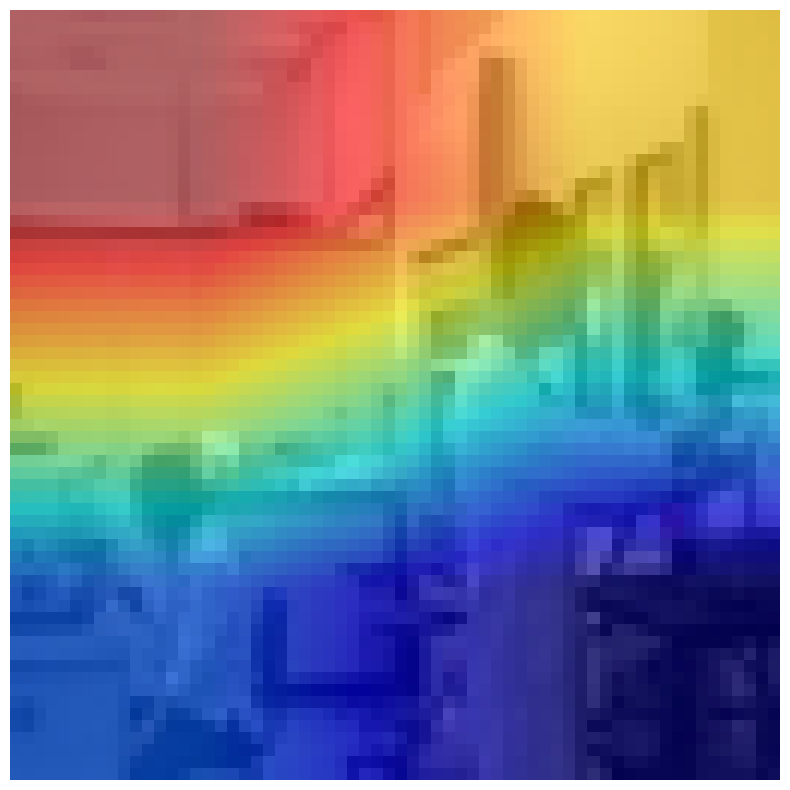

In [57]:
model = load_model("/kaggle/working/ResNet-18___Date_Time_2024_07_19__07_45_13___Loss_0___Accuracy_0.pth_entire")
target_layer = model.layer4[-1].conv2
img_path = '/kaggle/input/fake-or-real-dataset/test/images/test_00148.png'

generate_gradcam(model, target_layer, img_path)